#📌 Extracción

In [56]:
# Extracción de datos desde la API (GitHub Raw) y conversión a DataFrame
# Se intenta primero con pandas.read_json (suficiente para JSON estructurado en lista / dict).
# Si se necesitara más control, se muestra también la alternativa con requests.

import pandas as pd
import json
from pathlib import Path

RAW_URL = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/main/TelecomX_Data.json"

# Directorio centralizado de datos
DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

try:
    df = pd.read_json(RAW_URL)
except ValueError:
    # Fallback más robusto si el JSON está anidado y read_json directo falla
    import requests
    resp = requests.get(RAW_URL, timeout=30)
    resp.raise_for_status()
    data = resp.json()
    # Intentamos detectar estructura
    if isinstance(data, list):
        df = pd.DataFrame(data)
    elif isinstance(data, dict):
        # Si es un dict con una clave principal que contiene la lista de registros
        # Buscamos la primera lista dentro
        list_candidate = None
        for v in data.values():
            if isinstance(v, list):
                list_candidate = v
                break
        if list_candidate is not None:
            df = pd.DataFrame(list_candidate)
        else:
            # Último recurso: normalización completa
            from pandas import json_normalize
            df = json_normalize(data)
    else:
        raise RuntimeError("Formato JSON no soportado para conversión a DataFrame")

# Información básica
print("Filas, Columnas:", df.shape)
print("Columnas:")
print(df.columns.tolist())
print("\nTipos:")
print(df.dtypes.head())

# Vista rápida
display(df.head())

# (Opcional) Guardar copia local para trabajo offline
OUTPUT_FILE = DATA_DIR / "TelecomX_Data_local.parquet"
try:
    df.to_parquet(OUTPUT_FILE, index=False)
    print(f"Archivo guardado localmente en {OUTPUT_FILE.resolve()}")
except Exception as e:
    print("No se pudo guardar en Parquet (puede faltar pyarrow o fastparquet).", e)


Filas, Columnas: (7267, 6)
Columnas:
['customerID', 'Churn', 'customer', 'phone', 'internet', 'account']

Tipos:
customerID    object
Churn         object
customer      object
phone         object
internet      object
dtype: object


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


Archivo guardado localmente en C:\Users\USER\Documents\data-science-especialización\challenges\Challenge Telecom X análisis de evasión de clientes\data\TelecomX_Data_local.parquet


#🔧 Transformación

### 2.1 Conoce el conjunto de datos
Esta sección (ya implementada en las celdas siguientes) explora:
- Forma, tipos y resumen (`shape`, `dtypes`, `info`).
- Posible variable objetivo *Churn*.
- Agrupación de variables por prefijo para construir un diccionario derivado.
- Relevancia simple de variables (correlación para numéricas / diferencia de tasas para categóricas) y opcional Mutual Information.

➡️ Continúa con la detección y manejo de incoherencias en los datos.

---
### 2.2 Comprobación de incoherencias en los datos
Objetivo: identificar valores ausentes, duplicados, errores de formato y categorías inconsistentes.
Ya se cubre en una celda de "calidad" que genera: duplicados, nulos, candidatos numéricos mal tipados, inconsistencias categóricas, fechas potenciales y cardinalidad alta.

📌 Tips:
- `pandas.unique()` para inspeccionar categorías.
- `Series.dt.normalize()` para homogenizar fechas.

---
### 2.3 Manejo de inconsistencias
Aplicaremos correcciones basadas en lo detectado:
- Normalización de espacios y capitalización en categóricas.
- Conversión de columnas *object* casi numéricas.
- Unificación de categorías binarias (Yes/No, Sí/No) a 1/0.
- Conversión opcional de fechas detectadas.

---
### 2.4 Columna de Cuentas_Diarias
Creación de la columna `Cuentas_Diarias` a partir de la facturación mensual (ej.: `MonthlyCharges` / 30). Si existen múltiples candidatos se elige el más plausible.

---
### 2.5 Estandarización y transformación (opcional)
Acciones opcionales para mejorar interpretabilidad / preparación de modelado:
- Traducción / renombrado de columnas.
- Escalado / normalización numérica.
- Codificación binaria (ya parcialmente aplicada).

---

In [57]:
# Paso 1: Exploración rápida de estructura antes de expandir diccionarios
# (Orden solicitado: 1) explorar columnas y tipos
if 'df' not in globals():
    raise RuntimeError("Primero ejecuta la celda de Extracción para crear el DataFrame 'df'.")

print("== Forma inicial ==")
print(df.shape)
print("\n== Tipos de datos (df.dtypes) ==")
print(df.dtypes)
print("\n== df.info() ==")
import io
buf = io.StringIO()
df.info(buf=buf, verbose=True, show_counts=True)
print(buf.getvalue())

import pandas as pd
summary_types = df.dtypes.value_counts()
print("== Conteo de tipos ==")
print(summary_types)

display(df.head())

# Paso 2: Transformación – expansión de columnas diccionario y tipificación básica
from pathlib import Path
from pandas import json_normalize
DATA_DIR = Path('data')
DATA_DIR.mkdir(parents=True, exist_ok=True)

nested_cols = [c for c in df.columns if df[c].apply(lambda x: isinstance(x, dict)).any()]
print(f"\nColumnas anidadas detectadas: {nested_cols}")

def expand_dict_columns(dataframe, cols, prefix=True):
    out_df = dataframe.copy()
    for col in cols:
        safe_series = out_df[col].apply(lambda x: x if isinstance(x, dict) else {})
        expanded = json_normalize(safe_series)
        if prefix:
            expanded = expanded.add_prefix(f"{col}_")
        out_df = pd.concat([out_df.drop(columns=[col]), expanded], axis=1)
    return out_df

expanded_df = expand_dict_columns(df, nested_cols, prefix=True)
print("Forma original:", df.shape, "-> Forma expandida:", expanded_df.shape)

# Tipificación específica (ejemplo TotalCharges)
for candidate in ["account_TotalCharges", "TotalCharges", "account_totalCharges", "account_Totalcharges"]:
    if candidate in expanded_df.columns:
        expanded_df[candidate] = pd.to_numeric(expanded_df[candidate], errors='coerce')

# Mapear Yes/No a 1/0 cuando proceda
yes_no_map = {"Yes": 1, "No": 0, "Yes ": 1, "No ": 0}
for col in expanded_df.select_dtypes(include=['object']).columns:
    uniques = set(expanded_df[col].dropna().unique())
    if uniques.issubset(set(yes_no_map.keys()) | {"", " "}):
        expanded_df[col] = expanded_df[col].map(yes_no_map)

display(expanded_df.head())

TRANSFORM_FILE = DATA_DIR / "TelecomX_transformado.parquet"
expanded_df.to_parquet(TRANSFORM_FILE, index=False)
print(f"Dataset transformado guardado en {TRANSFORM_FILE.resolve()}")

df_model = expanded_df.copy()
print("Variable df_model lista para análisis/modelado (continuar con diccionario y relevancia).")

== Forma inicial ==
(7267, 6)

== Tipos de datos (df.dtypes) ==
customerID    object
Churn         object
customer      object
phone         object
internet      object
account       object
dtype: object

== df.info() ==
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB

== Conteo de tipos ==
object    6
Name: count, dtype: int64


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."



Columnas anidadas detectadas: ['customer', 'phone', 'internet', 'account']
Forma original: (7267, 6) -> Forma expandida: (7267, 21)
Forma original: (7267, 6) -> Forma expandida: (7267, 21)


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges.Monthly,account_Charges.Total
0,0002-ORFBO,0.0,Female,0,1,1,9,1,No,DSL,...,Yes,No,Yes,Yes,No,One year,1,Mailed check,65.6,593.3
1,0003-MKNFE,0.0,Male,0,0,0,9,1,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,0,Mailed check,59.9,542.4
2,0004-TLHLJ,1.0,Male,0,0,0,4,1,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,1,Electronic check,73.9,280.85
3,0011-IGKFF,1.0,Male,1,1,0,13,1,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,1,Electronic check,98.0,1237.85
4,0013-EXCHZ,1.0,Female,1,1,0,3,1,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,1,Mailed check,83.9,267.4


Dataset transformado guardado en C:\Users\USER\Documents\data-science-especialización\challenges\Challenge Telecom X análisis de evasión de clientes\data\TelecomX_transformado.parquet
Variable df_model lista para análisis/modelado (continuar con diccionario y relevancia).


In [58]:
# Diccionario formal de variables (derivado) - genera data/dictionary_variables.csv
import pandas as pd
from pathlib import Path
import json

# Fallbacks para obtener df si no está en memoria
if 'df' not in globals():
    # Intentar cargar transformado
    t_path = Path('data') / 'TelecomX_transformado.parquet'
    raw_path = Path('data') / 'TelecomX_Data_local.parquet'
    if t_path.exists():
        try:
            df = pd.read_parquet(t_path)
            print('df cargado desde', t_path)
        except Exception as e:
            print('Error cargando transformado:', e)
    elif raw_path.exists():
        try:
            df = pd.read_parquet(raw_path)
            print('df cargado desde', raw_path)
        except Exception as e:
            print('Error cargando raw local:', e)
    else:
        # Último recurso: volver a leer desde URL
        try:
            RAW_URL = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/main/TelecomX_Data.json"
            df = pd.read_json(RAW_URL)
            print('df reconstruido desde RAW_URL')
        except Exception as e:
            raise RuntimeError('No se pudo reconstruir df para el diccionario.') from e

rows = []
for col in df.columns:
    ser = df[col]
    dtype = str(ser.dtype)
    n_null = int(ser.isna().sum())
    # For columns with dicts, convert to string before getting unique values
    if ser.apply(lambda x: isinstance(x, dict)).any():
        ser_str = ser.dropna().apply(lambda x: json.dumps(x, ensure_ascii=False) if isinstance(x, dict) else str(x))
        n_unique = int(ser_str.nunique())
        sample_vals = ser_str.unique()[:5]
    else:
        n_unique = int(ser.nunique(dropna=True))
        sample_vals = ser.dropna().unique()[:5]
    # Convert sample values to serializable types
    sample_serializable = [str(v) for v in sample_vals]
    prefix = col.split('_')[0] if '_' in col else 'misc'
    rows.append({
        'columna': col,
        'prefijo': prefix,
        'dtype': dtype,
        'n_null': n_null,
        'pct_null': round(n_null/len(df)*100,2),
        'n_unique': n_unique,
        'sample_vals': sample_serializable
    })

var_dict = pd.DataFrame(rows)
Path('data').mkdir(exist_ok=True)
var_dict.to_csv('data/dictionary_variables.csv', index=False)
print('Diccionario de variables guardado en data/dictionary_variables.csv')
var_dict.head()

Diccionario de variables guardado en data/dictionary_variables.csv


,columna,prefijo,dtype,n_null,pct_null,n_unique,sample_vals
0,customerID,misc,object,0,0.0,7267,"[0002-ORFBO, 0003-MKNFE, 0004-TLHLJ, 0011-IGKF..."
1,Churn,misc,object,0,0.0,3,"[No, Yes, ]"
2,customer,misc,object,0,0.0,891,"[{""gender"": ""Female"", ""SeniorCitizen"": 0, ""Par..."
3,phone,misc,object,0,0.0,3,"[{""PhoneService"": ""Yes"", ""MultipleLines"": ""No""..."
4,internet,misc,object,0,0.0,129,"[{""InternetService"": ""DSL"", ""OnlineSecurity"": ..."


In [59]:
# === Exploración y selección preliminar de variables para evasión (churn) ===
import pandas as pd
import numpy as np
from pathlib import Path

# 1. Recuperar DataFrame transformado si no está en memoria
if 'df_model' not in globals():
    parquet_path = Path('data') / 'TelecomX_transformado.parquet'
    if parquet_path.exists():
        df_model = pd.read_parquet(parquet_path)
        print(f"df_model cargado desde {parquet_path}")
    else:
        raise RuntimeError("No se encontró df_model ni el archivo transformado. Ejecuta las celdas anteriores.")

print(f"Dimensión df_model: {df_model.shape}")

# 2. Identificar columna objetivo (target) posible: buscar 'Churn' (case-insensitive)
candidate_target_cols = [c for c in df_model.columns if 'churn' in c.lower()]
print("Columnas que parecen target (contienen 'Churn'):", candidate_target_cols)
if not candidate_target_cols:
    raise RuntimeError("No se detectó columna objetivo con 'Churn'. Verifica nombres.")
# Si hubiese más de una, elegir la última (o personalizar manualmente)
TARGET_COL = candidate_target_cols[-1]
print(f"Usando '{TARGET_COL}' como variable objetivo.")

# Asegurar binaria 0/1
if df_model[TARGET_COL].dtype == 'O':
    df_model[TARGET_COL] = df_model[TARGET_COL].str.strip().str.title().replace({'Yes':1,'No':0})

# 3. Construir "diccionario" derivado de prefijos (si la estructura original venía agrupada)
feature_groups = {}
for col in df_model.columns:
    if col == TARGET_COL: continue
    prefix = col.split('_')[0] if '_' in col else 'misc'
    feature_groups.setdefault(prefix, []).append(col)
print("Grupos de variables por prefijo (diccionario derivado):")
for k,v in feature_groups.items():
    print(f"  {k}: {len(v)} columnas")

# 4. Resumen de tipos, nulos, cardinalidad
summary_rows = []
for col in df_model.columns:
    ser = df_model[col]
    summary_rows.append({
        'col': col,
        'dtype': str(ser.dtype),
        'n_null': ser.isna().sum(),
        '%null': ser.isna().mean()*100,
        'n_unique': ser.nunique(),
        'sample_vals': ser.dropna().unique()[:5]
    })
summary_df = pd.DataFrame(summary_rows).sort_values('%null', ascending=False)
print("\nResumen de columnas (top 10 por mayor % de nulos):")
display(summary_df.head(10))

# 5. Separar tipo numérico vs categórico (excluyendo target)
Y = df_model[TARGET_COL]
feature_cols = [c for c in df_model.columns if c != TARGET_COL]
num_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df_model[c]) and df_model[c].nunique()>2]
cat_cols = [c for c in feature_cols if c not in num_cols]
print(f"Numéricas: {len(num_cols)} | Categóricas: {len(cat_cols)}")

# 6. Métricas de relevancia simples
relevance_records = []
# Numéricas: correlación punto-biserial (equivalente a Pearson con binaria)
for col in num_cols:
    ser = df_model[col]
    if ser.isna().all():
        continue
    corr = ser.corr(Y)
    relevance_records.append({'col': col, 'type': 'num', 'metric': abs(corr), 'detail': corr})

# Categóricas: diferencia máxima de tasa de churn entre categorías
for col in cat_cols:
    ser = df_model[col].fillna('NA')
    # Asegurar no cardinalidad extrema (evitar IDs)
    if ser.nunique() > 40:
        continue
    rates = Y.groupby(ser).mean()
    impact = rates.max() - rates.min()
    relevance_records.append({'col': col, 'type': 'cat', 'metric': impact, 'detail': rates.to_dict()})

relevance_df = pd.DataFrame(relevance_records).sort_values('metric', ascending=False)
print("\nTop 15 variables por métrica simple de relevancia:")
display(relevance_df.head(15))

# 7. (Opcional) Mutual Information para corroborar (si sklearn disponible)
try:
    from sklearn.feature_selection import mutual_info_classif
    from sklearn.preprocessing import OrdinalEncoder
    X_mi = df_model[feature_cols].copy()
    # Relleno simple
    for c in X_mi.columns:
        if pd.api.types.is_numeric_dtype(X_mi[c]):
            X_mi[c] = X_mi[c].fillna(X_mi[c].median())
        else:
            X_mi[c] = X_mi[c].fillna('NA')
    # Codificación ordinal para categóricas
    enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_enc = X_mi.copy()
    if cat_cols:
        X_enc[cat_cols] = enc.fit_transform(X_enc[cat_cols])
    mi_scores = mutual_info_classif(X_enc, Y, discrete_features=[c in cat_cols for c in X_enc.columns], random_state=42)
    mi_df = pd.DataFrame({'col': X_enc.columns, 'mutual_info': mi_scores}).sort_values('mutual_info', ascending=False)
    print("\nMutual Information (top 15):")
    display(mi_df.head(15))
except Exception as e:
    print("Saltando Mutual Information (instala scikit-learn si lo necesitas):", e)

# 8. Selección preliminar de columnas relevantes (umbral simple)
important_cols = relevance_df.query('metric > 0.02')['col'].tolist()  # umbral heurístico
print(f"\nColumnas preliminarmente relevantes (metric > 0.02): {len(important_cols)}")
print(important_cols)

# Guardar artefactos de exploración
summary_df.to_csv('data/summary_columns.csv', index=False)
relevance_df.to_csv('data/relevance_simple.csv', index=False)
if 'mi_df' in locals():
    mi_df.to_csv('data/relevance_mutual_info.csv', index=False)
print("Archivos de exploración guardados en carpeta data.")

# Nota: Ajusta criterios según necesites (umbral, excluir colinealidad, etc.)

Dimensión df_model: (7267, 21)
Columnas que parecen target (contienen 'Churn'): ['Churn']
Usando 'Churn' como variable objetivo.
Grupos de variables por prefijo (diccionario derivado):
  misc: 1 columnas
  customer: 5 columnas
  phone: 2 columnas
  internet: 7 columnas
  account: 5 columnas

Resumen de columnas (top 10 por mayor % de nulos):

Resumen de columnas (top 10 por mayor % de nulos):


,col,dtype,n_null,%null,n_unique,sample_vals
1,Churn,float64,224,3.082427,2,"[0.0, 1.0]"
0,customerID,object,0,0.000000,7267,"[0002-ORFBO, 0003-MKNFE, 0004-TLHLJ, 0011-IGKF..."
2,customer_gender,object,0,0.000000,2,"[Female, Male]"
3,customer_SeniorCitizen,int64,0,0.000000,2,"[0, 1]"
4,customer_Partner,int64,0,0.000000,2,"[1, 0]"
5,customer_Dependents,int64,0,0.000000,2,"[1, 0]"
6,customer_tenure,int64,0,0.000000,73,"[9, 4, 13, 3, 71]"
7,phone_PhoneService,int64,0,0.000000,2,"[1, 0]"
8,phone_MultipleLines,object,0,0.000000,3,"[No, Yes, No phone service]"
9,internet_InternetService,object,0,0.000000,3,"[DSL, Fiber optic, No]"


Numéricas: 2 | Categóricas: 18

Top 15 variables por métrica simple de relevancia:

Top 15 variables por métrica simple de relevancia:


,col,type,metric,detail
15,account_Contract,cat,0.398778,"{'Month-to-month': 0.4270967741935484, 'One ye..."
0,customer_tenure,num,0.352229,-0.352229
8,internet_InternetService,cat,0.344878,"{'DSL': 0.1895910780669145, 'Fiber optic': 0.4..."
9,internet_OnlineSecurity,cat,0.343617,"{'No': 0.4176672384219554, 'No internet servic..."
12,internet_TechSupport,cat,0.342305,"{'No': 0.4163547365390153, 'No internet servic..."
10,internet_OnlineBackup,cat,0.325238,"{'No': 0.39928756476683935, 'No internet servi..."
11,internet_DeviceProtection,cat,0.317226,"{'No': 0.3912762520193861, 'No internet servic..."
17,account_PaymentMethod,cat,0.300423,{'Bank transfer (automatic)': 0.16709844559585...
14,internet_StreamingMovies,cat,0.262755,"{'No': 0.33680430879712747, 'No internet servi..."
13,internet_StreamingTV,cat,0.261182,"{'No': 0.33523131672597867, 'No internet servi..."


Saltando Mutual Information (instala scikit-learn si lo necesitas): Input y contains NaN.

Columnas preliminarmente relevantes (metric > 0.02): 16
['account_Contract', 'customer_tenure', 'internet_InternetService', 'internet_OnlineSecurity', 'internet_TechSupport', 'internet_OnlineBackup', 'internet_DeviceProtection', 'account_PaymentMethod', 'internet_StreamingMovies', 'internet_StreamingTV', 'account_Charges.Monthly', 'customer_SeniorCitizen', 'account_PaperlessBilling', 'customer_Dependents', 'customer_Partner', 'phone_MultipleLines']
Archivos de exploración guardados en carpeta data.


c:\Users\USER\Documents\data-science-especialización\challenges\Challenge Telecom X análisis de evasión de clientes\.venv\Lib\site-packages\sklearn\externals\array_api_compat\numpy\_aliases.py:125: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype=dtype, copy=copy)


In [60]:
# Paso 3: Construcción de diccionario simplificado y relevancia preliminar

if 'df_model' not in globals():
    path_parquet = Path('data') / 'TelecomX_transformado.parquet'
    if not path_parquet.exists():
        raise RuntimeError("Ejecuta antes las celdas de extracción y transformación.")
    df_model = pd.read_parquet(path_parquet)

print("Dimensión:", df_model.shape)

# 1. Duplicados
n_dup_rows = df_model.duplicated().sum()
print(f"Filas duplicadas (completas): {n_dup_rows}")

# 2. Resumen de nulos
null_summary = (df_model.isna().sum()
                .to_frame('n_null')
                .assign(pct=lambda d: d.n_null/len(df_model)*100)
                .sort_values('pct', ascending=False))
print("\nTop columnas con nulos:")
display(null_summary.head(15))

# Guardar resumen de nulos
null_summary.to_csv('data/quality_nulls.csv')

# 3. Detección de columnas object que parecen numéricas (posibles errores de formato)
candidate_numeric = []
for c in df_model.select_dtypes(include='object').columns:
    ser = df_model[c].dropna()
    if ser.empty: 
        continue
    # proporción de valores que se convierten a número
    conv = pd.to_numeric(ser, errors='coerce')
    ratio = conv.notna().mean()
    if ratio > 0.95:  # umbral
        candidate_numeric.append((c, ratio))
if candidate_numeric:
    print("\nColumnas object que son casi numéricas (revisar conversión):")
    for c, r in candidate_numeric:
        print(f"  {c} -> {r:.1%} convertibles")

# 4. Inconsistencias de categorías (espacios / mayúsculas-minúsculas)
cat_issues = []
for c in df_model.select_dtypes(include='object').columns:
    ser = df_model[c].dropna()
    if ser.empty:
        continue
    normalized = ser.str.strip().str.lower()
    if normalized.nunique() < ser.nunique():
        diff = ser.nunique() - normalized.nunique()
        cat_issues.append((c, diff, ser.nunique(), normalized.nunique()))
if cat_issues:
    print("\nColumnas con posibles inconsistencias de formato en categorías:")
    for c, diff, orig_u, norm_u in cat_issues:
        print(f"  {c}: {orig_u} -> {norm_u} (reducción {diff})")
    # Ejemplo de corrección (no se aplica automáticamente para que revises):
    # df_model['col'] = df_model['col'].str.strip().str.title()

# 5. Fechas: intentar detectar columnas convertibles a datetime
datetime_candidates = []
for c in df_model.columns:
    if df_model[c].dtype == 'object':
        sample = df_model[c].dropna()
        if sample.empty:
            continue
        parsed = pd.to_datetime(sample, errors='coerce', utc=False, format=None)
        ratio = parsed.notna().mean()
        if ratio > 0.85:
            datetime_candidates.append((c, ratio))
if datetime_candidates:
    print("\nColumnas que podrían ser datetime (revisar):")
    for c, r in datetime_candidates:
        print(f"  {c}: {r:.1%} parseable")
    # Ejemplo:
    # df_model['fecha_normalizada'] = pd.to_datetime(df_model['fecha'], errors='coerce').dt.normalize()

# 6. Cardinalidad alta (posibles IDs a excluir del modelado)
high_card = []
for c in df_model.columns:
    uniq = df_model[c].nunique(dropna=True)
    if  uniq > 0.9 * len(df_model) and uniq > 50:
        high_card.append(c)
if high_card:
    print("\nColumnas de cardinalidad muy alta (posibles identificadores):")
    print(high_card)

# 7. Resumen final a CSV
quality_report = {
    'n_rows': [len(df_model)],
    'n_cols': [df_model.shape[1]],
    'duplicate_rows': [n_dup_rows],
    'cols_with_nulls': [(null_summary.query('n_null>0').shape[0])],
    'possible_numeric_objects': [len(candidate_numeric)],
    'category_inconsistency_cols': [len(cat_issues)],
    'datetime_candidates': [len(datetime_candidates)],
    'high_cardinality_cols': [len(high_card)]
}
pd.DataFrame(quality_report).to_csv('data/quality_overview.csv', index=False)
print("\nArchivos guardados: data/quality_nulls.csv, data/quality_overview.csv")


Dimensión: (7267, 21)
Filas duplicadas (completas): 0

Top columnas con nulos:


,n_null,pct
Churn,224,3.082427
customerID,0,0.000000
customer_gender,0,0.000000
customer_SeniorCitizen,0,0.000000
customer_Partner,0,0.000000
customer_Dependents,0,0.000000
customer_tenure,0,0.000000
phone_PhoneService,0,0.000000
phone_MultipleLines,0,0.000000
internet_InternetService,0,0.000000



Columnas object que son casi numéricas (revisar conversión):
  account_Charges.Total -> 99.8% convertibles


C:\Users\USER\AppData\Local\Temp\ipykernel_24764\2297463338.py:66: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(sample, errors='coerce', utc=False, format=None)
C:\Users\USER\AppData\Local\Temp\ipykernel_24764\2297463338.py:66: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(sample, errors='coerce', utc=False, format=None)
C:\Users\USER\AppData\Local\Temp\ipykernel_24764\2297463338.py:66: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(sample, errors='coerce', utc=False, format=None)
C:\Users\USER\AppData\


Columnas de cardinalidad muy alta (posibles identificadores):
['customerID']

Archivos guardados: data/quality_nulls.csv, data/quality_overview.csv


In [61]:
# Detectar y expandir columnas que contienen diccionarios anidados
import pandas as pd
import numpy as np
from pathlib import Path

# Asegurar directorio de datos coherente con la fase de extracción
DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Asumimos que el DataFrame original se llama df (creado en la fase de extracción)
# Si vienes a esta celda sin haber ejecutado la anterior, vuelve y ejecútala primero.

# 1. Identificar columnas con valores tipo dict
nested_cols = [c for c in df.columns if df[c].apply(lambda x: isinstance(x, dict)).any()]
print(f"Columnas anidadas detectadas: {nested_cols}")

# 2. Función para expandir de forma segura cada columna dict
from pandas import json_normalize

def expand_dict_columns(dataframe, cols, prefix=True):
    out_df = dataframe.copy()
    for col in cols:
        # Normalizamos; ignoramos filas que no sean dict sustituyéndolas por {} para evitar errores
        safe_series = out_df[col].apply(lambda x: x if isinstance(x, dict) else {})
        expanded = json_normalize(safe_series)
        # Prefijos para evitar colisiones de nombres
        if prefix:
            expanded = expanded.add_prefix(f"{col}_")
        # Unir y eliminar la original
        out_df = pd.concat([out_df.drop(columns=[col]), expanded], axis=1)
    return out_df

expanded_df = expand_dict_columns(df, nested_cols, prefix=True)
print("Forma original:", df.shape, "-> Forma expandida:", expanded_df.shape)

# 3. Tipificación básica (ejemplos)
# Convertir TotalCharges si existe y está como texto
for candidate in ["account_TotalCharges", "TotalCharges", "account_totalCharges", "account_Totalcharges"]:
    if candidate in expanded_df.columns:
        expanded_df[candidate] = pd.to_numeric(expanded_df[candidate], errors='coerce')

# Mapear Yes/No habituales a 1/0 (sin tocar columnas que no sean objet/boolean)
yes_no_map = {"Yes": 1, "No": 0, "Yes ": 1, "No ": 0}
for col in expanded_df.select_dtypes(include=['object']).columns:
    uniques = set(expanded_df[col].dropna().unique())
    if uniques.issubset(set(yes_no_map.keys()) | {"", " "}):
        expanded_df[col] = expanded_df[col].map(yes_no_map)

# 4. Mostrar vista previa
display(expanded_df.head())

# 5. Guardar resultado intermedio en carpeta data
TRANSFORM_FILE = DATA_DIR / "TelecomX_transformado.parquet"
expanded_df.to_parquet(TRANSFORM_FILE, index=False)
print(f"Dataset transformado guardado en {TRANSFORM_FILE.resolve()}")

# Dejamos el DataFrame transformado en una variable principal para siguientes pasos
df_model = expanded_df.copy()
print("Variable df_model lista para análisis/modelado.")

Columnas anidadas detectadas: ['customer', 'phone', 'internet', 'account']
Forma original: (7267, 6) -> Forma expandida: (7267, 21)
Forma original: (7267, 6) -> Forma expandida: (7267, 21)


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges.Monthly,account_Charges.Total
0,0002-ORFBO,0.0,Female,0,1,1,9,1,No,DSL,...,Yes,No,Yes,Yes,No,One year,1,Mailed check,65.6,593.3
1,0003-MKNFE,0.0,Male,0,0,0,9,1,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,0,Mailed check,59.9,542.4
2,0004-TLHLJ,1.0,Male,0,0,0,4,1,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,1,Electronic check,73.9,280.85
3,0011-IGKFF,1.0,Male,1,1,0,13,1,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,1,Electronic check,98.0,1237.85
4,0013-EXCHZ,1.0,Female,1,1,0,3,1,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,1,Mailed check,83.9,267.4


Dataset transformado guardado en C:\Users\USER\Documents\data-science-especialización\challenges\Challenge Telecom X análisis de evasión de clientes\data\TelecomX_transformado.parquet
Variable df_model lista para análisis/modelado.


In [62]:
# === 2.3 Manejo de inconsistencias / 2.4 Columna Cuentas_Diarias / 2.5 Estandarización opcional ===
import pandas as pd
from pathlib import Path

# Cargar dataset transformado si no está en memoria
if 'df_model' not in globals():
    path_parquet = Path('data') / 'TelecomX_transformado.parquet'
    if not path_parquet.exists():
        raise RuntimeError("Ejecuta las celdas previas de extracción y transformación.")
    df_model = pd.read_parquet(path_parquet)

print('Shape inicial para limpieza:', df_model.shape)

# Copia de trabajo
clean_df = df_model.copy()

# 2.3.1 Normalizar espacios y casing en columnas categóricas (solo object con cardinalidad manejable)
for c in clean_df.select_dtypes(include='object').columns:
    ser = clean_df[c]
    if ser.nunique(dropna=True) <= 1000:  # límite arbitrario para no procesar IDs enormes
        clean_df[c] = ser.str.strip().str.replace(r'\s+', ' ', regex=True)
        # Uniformar variantes de yes/no en inglés/español
        clean_df[c] = clean_df[c].str.lower().replace({
            'yes': 'yes', 'no': 'no',
            'si': 'yes', 'sí': 'yes', 'na': 'na'
        })

# 2.3.2 Convertir columnas object casi numéricas (heurística >95% convertible)
for c in clean_df.select_dtypes(include='object').columns:
    ser = clean_df[c]
    # Saltar si ya mapeamos yes/no a categorías pequeñas
    if ser.nunique() <= 5:
        continue
    conv = pd.to_numeric(ser, errors='coerce')
    if conv.notna().mean() > 0.95:
        clean_df[c] = conv

# 2.3.3 Unificación binaria Yes/No a 1/0
binary_map = {'yes': 1, 'no': 0}
for c in clean_df.select_dtypes(include='object').columns:
    uniques = set(clean_df[c].dropna().unique())
    if uniques.issubset(set(binary_map.keys()) | {'na'}):
        clean_df[c] = clean_df[c].map(binary_map)

# 2.3.4 Conversión de posibles fechas detectadas previamente
possible_date_cols = []
for c in clean_df.columns:
    if clean_df[c].dtype == 'object':
        sample = clean_df[c].dropna()
        if sample.empty:
            continue
        parsed = pd.to_datetime(sample, errors='coerce', format=None)
        if parsed.notna().mean() > 0.90:  # umbral más estricto aquí
            possible_date_cols.append(c)
            clean_df[c] = pd.to_datetime(clean_df[c], errors='coerce').dt.normalize()
if possible_date_cols:
    print('Columnas convertidas a fecha:', possible_date_cols)

# 2.4 Crear columna Cuentas_Diarias
# Se intentan nombres comunes para cargo mensual
monthly_candidates = [c for c in clean_df.columns if 'monthly' in c.lower() and 'charge' in c.lower()]
cuentas_diarias_col = None
if monthly_candidates:
    base_col = monthly_candidates[0]
    clean_df['Cuentas_Diarias'] = pd.to_numeric(clean_df[base_col], errors='coerce') / 30.0
    cuentas_diarias_col = base_col
    print(f"Columna 'Cuentas_Diarias' creada a partir de {base_col}")
else:
    print('No se encontró columna de cargos mensuales para derivar Cuentas_Diarias.')

# 2.5 Estandarización / escalado opcional (solo demostración, no se sobreescribe)
from sklearn.preprocessing import StandardScaler
scaled_preview = None
numeric_cols = [c for c in clean_df.columns if pd.api.types.is_numeric_dtype(clean_df[c])]
if numeric_cols:
    scaler = StandardScaler()
    sample_numeric = clean_df[numeric_cols].fillna(clean_df[numeric_cols].median())
    scaled_arr = scaler.fit_transform(sample_numeric[numeric_cols[:10]])  # muestra de primeras 10 numéricas
    scaled_preview = pd.DataFrame(scaled_arr, columns=[f'std_{c}' for c in numeric_cols[:10]]).head()

# Guardar dataset limpio
CLEAN_FILE = Path('data') / 'TelecomX_limpio.parquet'
clean_df.to_parquet(CLEAN_FILE, index=False)
print(f"Dataset limpio guardado en {CLEAN_FILE.resolve()}")

# Mostrar vista previa y escalado opcional
display(clean_df.head())
if scaled_preview is not None:
    print('\nVista previa de columnas estandarizadas (subset):')
    display(scaled_preview)

# Reemplazar df_model para siguientes fases
df_model = clean_df
print('df_model actualizado con limpieza y nuevas columnas (incluyendo Cuentas_Diarias si disponible).')

Shape inicial para limpieza: (7267, 21)


C:\Users\USER\AppData\Local\Temp\ipykernel_24764\221143246.py:52: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(sample, errors='coerce', format=None)


Columna 'Cuentas_Diarias' creada a partir de account_Charges.Monthly
Dataset limpio guardado en C:\Users\USER\Documents\data-science-especialización\challenges\Challenge Telecom X análisis de evasión de clientes\data\TelecomX_limpio.parquet


C:\Users\USER\AppData\Local\Temp\ipykernel_24764\221143246.py:52: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(sample, errors='coerce', format=None)
C:\Users\USER\AppData\Local\Temp\ipykernel_24764\221143246.py:52: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(sample, errors='coerce', format=None)
C:\Users\USER\AppData\Local\Temp\ipykernel_24764\221143246.py:52: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(sample, errors='coerce', format=None)
C:\Users\USER\AppData\Local\Temp\ipykernel_24764\221143246

,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges.Monthly,account_Charges.Total,Cuentas_Diarias
0,0002-ORFBO,0.0,female,0,1,1,9,1,no,dsl,...,no,yes,yes,no,one year,1,mailed check,65.6,593.30,2.186667
1,0003-MKNFE,0.0,male,0,0,0,9,1,yes,dsl,...,no,no,no,yes,month-to-month,0,mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,1.0,male,0,0,0,4,1,no,fiber optic,...,yes,no,no,no,month-to-month,1,electronic check,73.9,280.85,2.463333
3,0011-IGKFF,1.0,male,1,1,0,13,1,no,fiber optic,...,yes,no,yes,yes,month-to-month,1,electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,1.0,female,1,1,0,3,1,no,fiber optic,...,no,yes,yes,no,month-to-month,1,mailed check,83.9,267.40,2.796667



Vista previa de columnas estandarizadas (subset):


,std_Churn,std_customer_SeniorCitizen,std_customer_Partner,std_customer_Dependents,std_customer_tenure,std_phone_PhoneService,std_account_PaperlessBilling,std_account_Charges.Monthly,std_account_Charges.Total,std_Cuentas_Diarias
0,-0.588421,-0.440736,1.032309,1.527075,-0.950200,0.32829,0.828063,0.029206,-0.743701,0.029206
1,-0.588421,-0.440736,-0.968702,-0.654847,-0.950200,0.32829,-1.207638,-0.159990,-0.766154,-0.159990
2,1.699463,-0.440736,-0.968702,-0.654847,-1.153700,0.32829,0.828063,0.304702,-0.881525,0.304702
3,1.699463,2.268932,1.032309,-0.654847,-0.787401,0.32829,0.828063,1.104635,-0.459386,1.104635
4,1.699463,2.268932,1.032309,-0.654847,-1.194400,0.32829,0.828063,0.636624,-0.887458,0.636624


df_model actualizado con limpieza y nuevas columnas (incluyendo Cuentas_Diarias si disponible).


In [63]:
# === 2.5 (Opcional ampliado) Traducción / Renombrado + Dataset listo para modelado ===
import pandas as pd
from pathlib import Path

if 'df_model' not in globals():
    raise RuntimeError('Necesitas ejecutar las celdas de limpieza previamente.')

opt_df = df_model.copy()

# Traducciones / renombres sugeridos si las columnas existen
rename_map = {
    'tenure': 'antiguedad_meses',
    'MonthlyCharges': 'cargo_mensual',
    'TotalCharges': 'cargos_totales',
    'Cuentas_Diarias': 'cuentas_diarias'
}
actual_map = {k:v for k,v in rename_map.items() if k in opt_df.columns and v not in opt_df.columns}
if actual_map:
    opt_df = opt_df.rename(columns=actual_map)
    print('Columnas renombradas:', actual_map)
else:
    print('No se encontraron columnas para renombrar según el mapa predefinido.')

# Separar target (detectar nuevamente por prudencia)
churn_cols = [c for c in opt_df.columns if 'churn' in c.lower()]
if not churn_cols:
    raise RuntimeError('No se halló columna churn para preparar dataset model.')
TARGET = churn_cols[-1]

# Identificar tipos
num_cols_all = [c for c in opt_df.columns if pd.api.types.is_numeric_dtype(opt_df[c]) and c != TARGET]
cat_cols_all = [c for c in opt_df.columns if c not in num_cols_all and c != TARGET]

# Relleno simple
model_df = opt_df.copy()
for c in num_cols_all:
    model_df[c] = pd.to_numeric(model_df[c], errors='coerce')
    model_df[c] = model_df[c].fillna(model_df[c].median())
for c in cat_cols_all:
    model_df[c] = model_df[c].astype(str).fillna('NA')

# Codificación one-hot (evitar expansión explosiva limitando cardinalidad)
low_card_cats = [c for c in cat_cols_all if model_df[c].nunique() <= 40]
high_card_cats = [c for c in cat_cols_all if model_df[c].nunique() > 40]
encoded_df = pd.get_dummies(model_df[low_card_cats], prefix=low_card_cats, drop_first=True)

# Concatenar numéricas + encoded + target
final_model_df = pd.concat([model_df[num_cols_all], encoded_df, model_df[[TARGET]]], axis=1)
print(f'Dataset model (sin escalado) shape: {final_model_df.shape}')

# Escalado estándar de numéricas
try:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    final_model_df[num_cols_all] = scaler.fit_transform(final_model_df[num_cols_all])
    scaled_applied = True
except Exception as e:
    print('No se pudo aplicar escalado (instala scikit-learn si lo necesitas):', e)
    scaled_applied = False

MODEL_READY_FILE = Path('data') / 'TelecomX_model_ready.parquet'
final_model_df.to_parquet(MODEL_READY_FILE, index=False)
print('Archivo de modelado guardado en', MODEL_READY_FILE)

# Guardar metadata de preparación
meta = {
    'target': TARGET,
    'num_cols': num_cols_all,
    'encoded_low_card_cats': low_card_cats,
    'ignored_high_card_cats': high_card_cats,
    'scaled_num': scaled_applied
}
import json
with open('data/model_prep_metadata.json','w', encoding='utf-8') as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)
print('Metadata guardada en data/model_prep_metadata.json')

# Vista rápida
display(final_model_df.head())

Columnas renombradas: {'Cuentas_Diarias': 'cuentas_diarias'}
Dataset model (sin escalado) shape: (7267, 32)
Archivo de modelado guardado en data\TelecomX_model_ready.parquet
Metadata guardada en data/model_prep_metadata.json
Archivo de modelado guardado en data\TelecomX_model_ready.parquet
Metadata guardada en data/model_prep_metadata.json


,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,account_PaperlessBilling,account_Charges.Monthly,account_Charges.Total,cuentas_diarias,customer_gender_male,...,internet_StreamingTV_no internet service,internet_StreamingTV_yes,internet_StreamingMovies_no internet service,internet_StreamingMovies_yes,account_Contract_one year,account_Contract_two year,account_PaymentMethod_credit card (automatic),account_PaymentMethod_electronic check,account_PaymentMethod_mailed check,Churn
0,-0.440736,1.032309,1.527075,-0.950200,0.32829,0.828063,0.029206,-0.743701,0.029206,False,...,False,True,False,False,True,False,False,False,True,0.0
1,-0.440736,-0.968702,-0.654847,-0.950200,0.32829,-1.207638,-0.159990,-0.766154,-0.159990,True,...,False,False,False,True,False,False,False,False,True,0.0
2,-0.440736,-0.968702,-0.654847,-1.153700,0.32829,0.828063,0.304702,-0.881525,0.304702,True,...,False,False,False,False,False,False,False,True,False,1.0
3,2.268932,1.032309,-0.654847,-0.787401,0.32829,0.828063,1.104635,-0.459386,1.104635,True,...,False,True,False,True,False,False,False,True,False,1.0
4,2.268932,1.032309,-0.654847,-1.194400,0.32829,0.828063,0.636624,-0.887458,0.636624,False,...,False,True,False,False,False,False,False,False,True,1.0


#📊 Carga y análisis

En esta sección se realiza el análisis exploratorio descriptivo enfocado en la variable de evasión (*Churn*).

### 3.1 Análisis Descriptivo
- Estadísticos generales (`describe`) para numéricas.
- Medidas de dispersión y distribución básica.

### 3.2 Distribución de Evasión (Churn)
- Conteo y porcentaje de churn vs no churn.
- Visualización: barras y pie (opcional).

### 3.3 Recuento de Evasión por Variables Categóricas
- Tablas cruzadas y proporciones de churn por categoría.
- Visualizaciones tipo barplot ordenadas por tasa de churn.

### 3.4 Evasión vs Variables Numéricas
- Distribuciones (hist/box) segmentadas por churn.
- Comparaciones de medias y test estadísticos simples (opcional).


Usando columna de churn: Churn

Estadísticos descriptivos (numéricas):


,count,mean,std,min,25%,50%,75%,max
customer_SeniorCitizen,7267.0,0.162653,0.369074,0.000000,0.000000,0.000000,0.000000,1.000000
customer_Partner,7267.0,0.484106,0.499782,0.000000,0.000000,0.000000,1.000000,1.000000
customer_Dependents,7267.0,0.300124,0.458343,0.000000,0.000000,0.000000,1.000000,1.000000
customer_tenure,7267.0,32.346498,24.571773,0.000000,9.000000,29.000000,55.000000,72.000000
phone_PhoneService,7267.0,0.902711,0.296371,0.000000,1.000000,1.000000,1.000000,1.000000
account_PaperlessBilling,7267.0,0.593230,0.491265,0.000000,0.000000,1.000000,1.000000,1.000000
account_Charges.Monthly,7267.0,64.720098,30.129572,18.250000,35.425000,70.300000,89.875000,118.750000
account_Charges.Total,7256.0,2280.634213,2268.632997,18.800000,400.225000,1391.000000,3785.300000,8684.800000
Cuentas_Diarias,7267.0,2.157337,1.004319,0.608333,1.180833,2.343333,2.995833,3.958333



Distribución churn (conteo / %):
       count    pct
Churn              
0.0     5174  71.20
1.0     1869  25.72
NaN      224   3.08


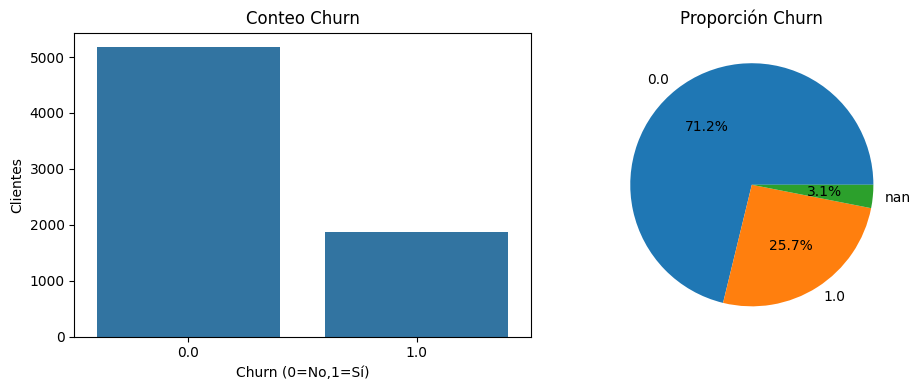


Top variables categóricas por spread de churn:


,feature,spread,n_levels
9,account_Contract,0.398778,3
2,internet_InternetService,0.344878,3
3,internet_OnlineSecurity,0.343617,3
6,internet_TechSupport,0.342305,3
4,internet_OnlineBackup,0.325238,3
5,internet_DeviceProtection,0.317226,3
10,account_PaymentMethod,0.300423,4
8,internet_StreamingMovies,0.262755,3
7,internet_StreamingTV,0.261182,3
1,phone_MultipleLines,0.036832,3


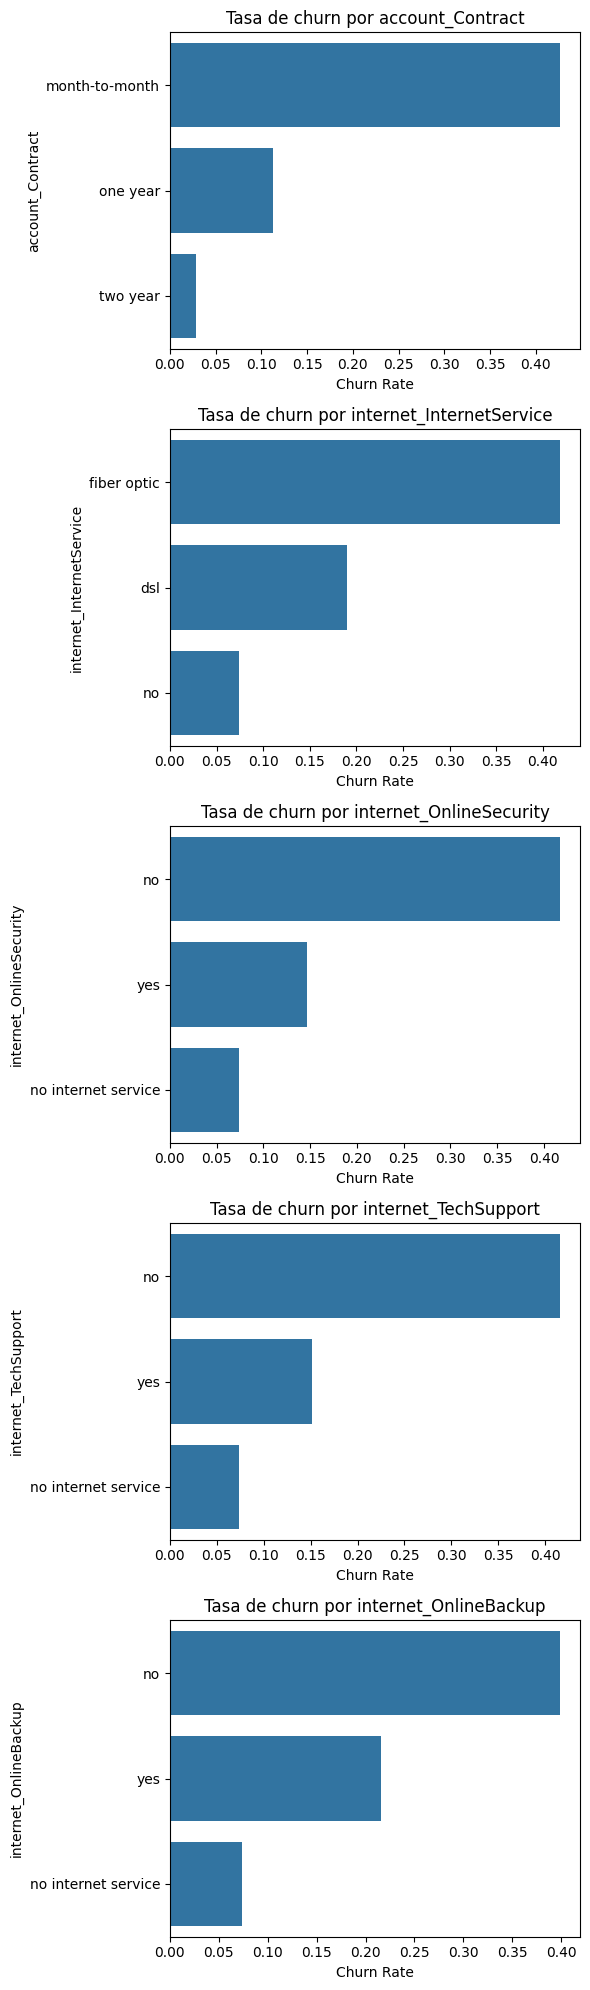


Diferencia de medias (Churn=1 - Churn=0) y test t (subset numéricas):


,feature,mean_no,mean_yes,diff,p_value
6,account_Charges.Monthly,61.265124,74.441332,13.176209,8.592449e-73
8,Cuentas_Diarias,2.042171,2.481378,0.439207,8.592449e-73
5,account_PaperlessBilling,0.535562,0.749064,0.213501,4.802979e-66
0,customer_SeniorCitizen,0.128721,0.254682,0.125961,3.587587e-29
4,phone_PhoneService,0.901044,0.909042,0.007999,3.078279e-01
1,customer_Partner,0.528218,0.357945,-0.170273,7.980266e-38
2,customer_Dependents,0.344801,0.174425,-0.170376,9.878649e-53
3,customer_tenure,37.569965,17.979133,-19.590832,1.195495e-232
7,account_Charges.Total,2555.344141,1531.796094,-1023.548047,1.152494e-75


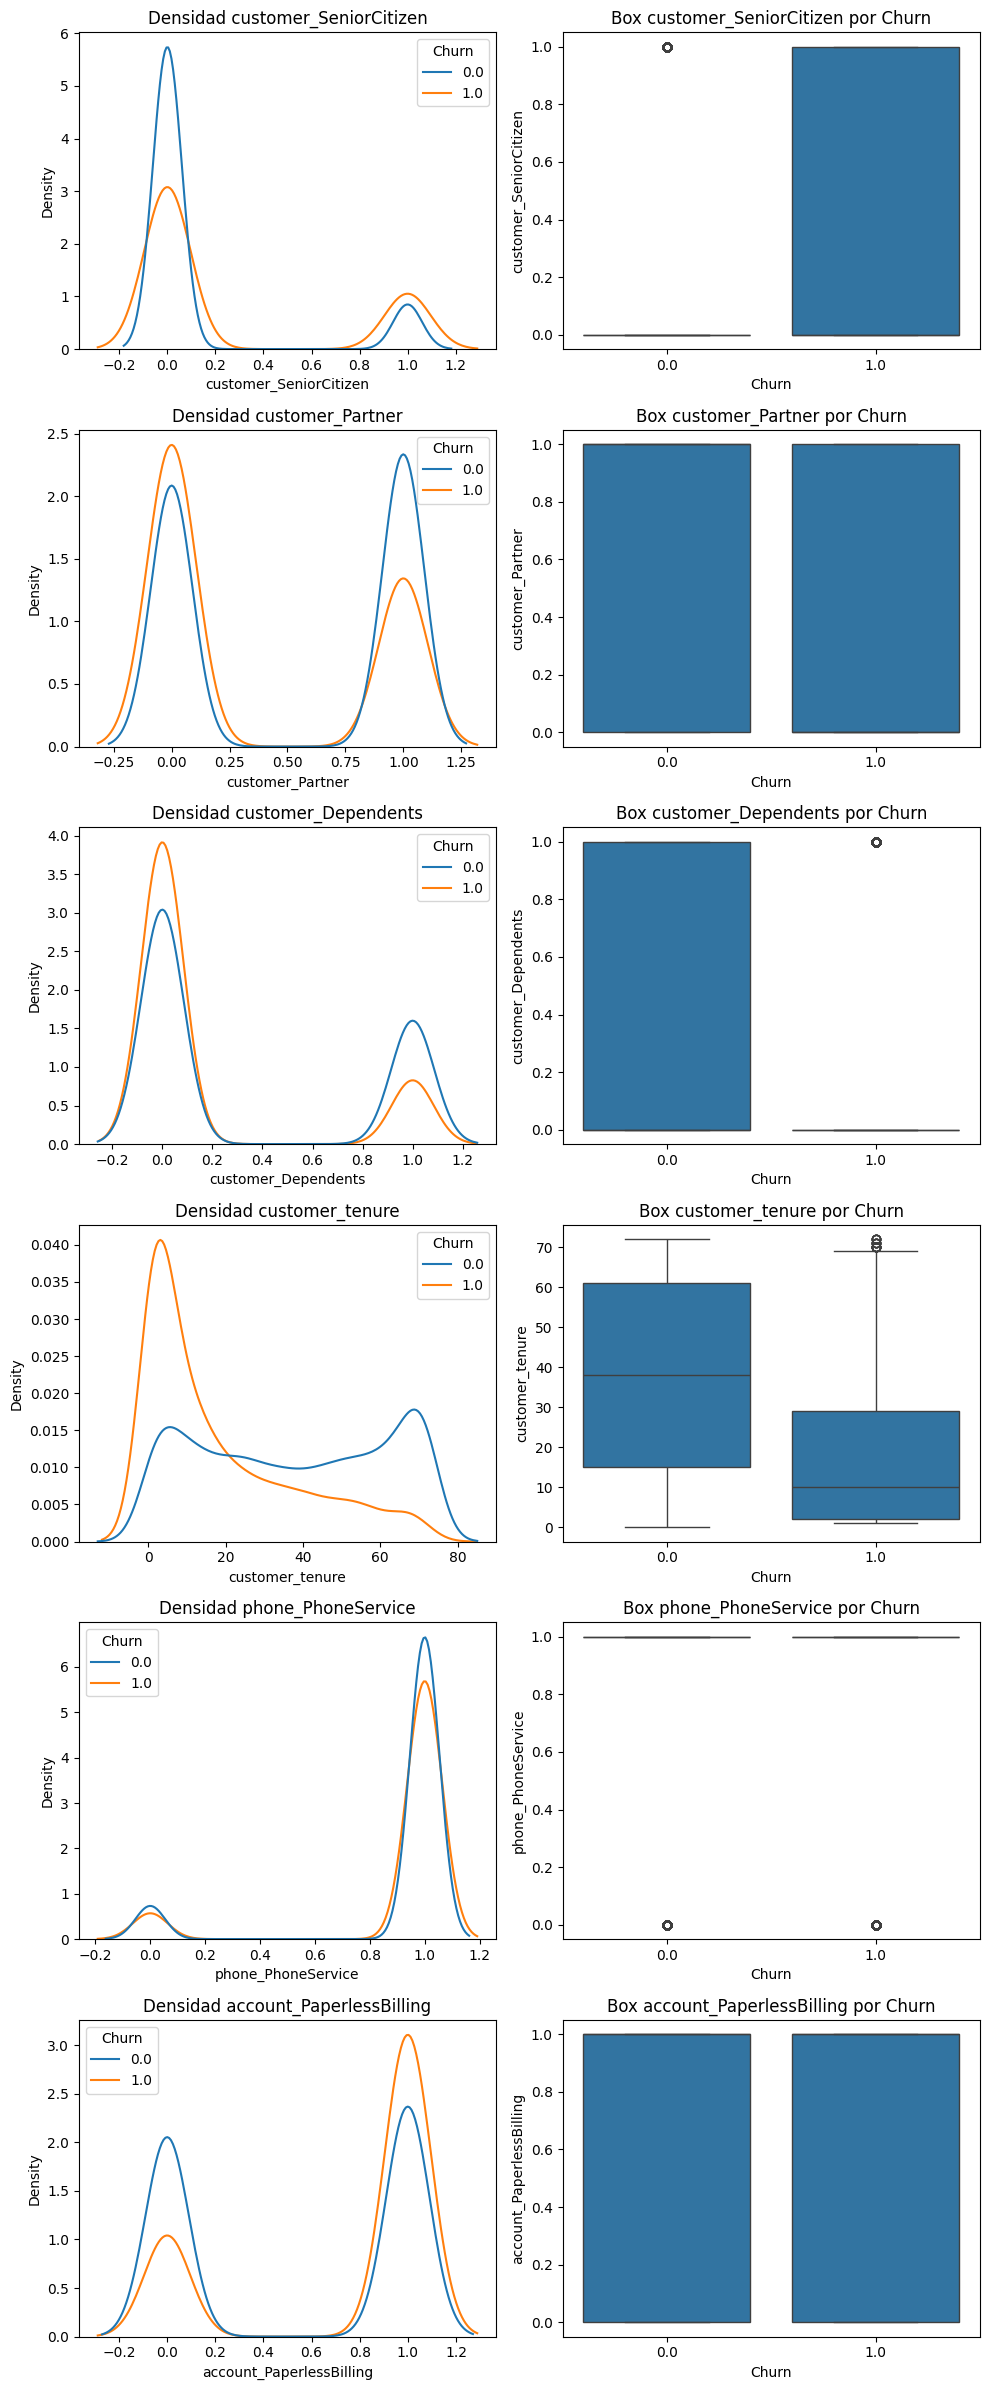

Archivos guardados: descriptive_numeric.csv, churn_categorical_spread.csv, churn_numeric_diff.csv


In [64]:
# === 3.1 a 3.4 Análisis Exploratorio Enfocado en Churn ===
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Cargar datos limpios
if 'df_model' not in globals():
    clean_path = Path('data') / 'TelecomX_limpio.parquet'
    if clean_path.exists():
        df_model = pd.read_parquet(clean_path)
    else:
        raise RuntimeError('Ejecuta las celdas de transformación y limpieza antes.')

# Localizar columna churn
churn_cols = [c for c in df_model.columns if 'churn' in c.lower()]
if not churn_cols:
    raise RuntimeError('No se encontró columna relacionada a churn.')
CHURN_COL = churn_cols[-1]

# Asegurar binaria 0/1
if not pd.api.types.is_numeric_dtype(df_model[CHURN_COL]):
    df_model[CHURN_COL] = (df_model[CHURN_COL].astype(str).str.lower().str.contains('yes|si|sí')).astype(int)

print('Usando columna de churn:', CHURN_COL)

# 3.1 Descriptivo
num_cols = [c for c in df_model.columns if pd.api.types.is_numeric_dtype(df_model[c]) and c != CHURN_COL]
cat_cols = [c for c in df_model.columns if c not in num_cols and c != CHURN_COL]

describe_df = df_model[num_cols].describe().T
print('\nEstadísticos descriptivos (numéricas):')
display(describe_df.head(15))

# 3.2 Distribución churn
churn_counts = df_model[CHURN_COL].value_counts(dropna=False)
churn_pct = churn_counts / churn_counts.sum() * 100
print('\nDistribución churn (conteo / %):')
print(pd.DataFrame({'count': churn_counts, 'pct': churn_pct.round(2)}))
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.countplot(x=df_model[CHURN_COL], ax=ax[0])
ax[0].set_title('Conteo Churn')
ax[0].set_xlabel('Churn (0=No,1=Sí)')
ax[0].set_ylabel('Clientes')
ax[1].pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%');
ax[1].set_title('Proporción Churn')
plt.tight_layout()
plt.show()

# 3.3 Churn por categóricas (top 6 por tasa de churn diferencia)
cat_summary_rows = []
for c in cat_cols:
    if df_model[c].nunique() > 30:  # evitar demasiado ruido
        continue
    grp = df_model.groupby(c)[CHURN_COL].agg(['mean','count'])
    grp = grp.rename(columns={'mean':'churn_rate'})
    grp['feature'] = c
    # diferencia entre categorías
    spread = grp['churn_rate'].max() - grp['churn_rate'].min()
    cat_summary_rows.append({'feature': c, 'spread': spread, 'n_levels': df_model[c].nunique()})

cat_spread_df = pd.DataFrame(cat_summary_rows).sort_values('spread', ascending=False)
print('\nTop variables categóricas por spread de churn:')
display(cat_spread_df.head(10))

# Visualizar las 5 más relevantes
top_cats = cat_spread_df.head(5)['feature'].tolist()
fig, axes = plt.subplots(len(top_cats), 1, figsize=(6,4*len(top_cats)))
if len(top_cats)==1:
    axes = [axes]
for ax, c in zip(axes, top_cats):
    order = df_model.groupby(c)[CHURN_COL].mean().sort_values(ascending=False).index
    sns.barplot(x=df_model.groupby(c)[CHURN_COL].mean().loc[order].values,
                y=order, ax=ax, orient='h')
    ax.set_title(f'Tasa de churn por {c}')
    ax.set_xlabel('Churn Rate')
plt.tight_layout()
plt.show()

# 3.4 Churn vs numéricas (densidad / box)
from scipy.stats import ttest_ind
num_stats_rows = []
for c in num_cols[:15]:  # limitar a primeras 15 para no saturar
    ser = pd.to_numeric(df_model[c], errors='coerce')
    g0 = ser[df_model[CHURN_COL]==0].dropna()
    g1 = ser[df_model[CHURN_COL]==1].dropna()
    if len(g0)>10 and len(g1)>10:
        stat, pval = ttest_ind(g0, g1, equal_var=False)
        num_stats_rows.append({'feature': c, 'mean_no': g0.mean(), 'mean_yes': g1.mean(), 'diff': g1.mean()-g0.mean(), 'p_value': pval})

num_diff_df = pd.DataFrame(num_stats_rows).sort_values('diff', ascending=False)
print('\nDiferencia de medias (Churn=1 - Churn=0) y test t (subset numéricas):')
display(num_diff_df.head(10))

# Gráficos de distribución para primeras 6 numéricas
plot_nums = num_cols[:6]
fig, axes = plt.subplots(len(plot_nums), 2, figsize=(10,4*len(plot_nums)))
for i, col in enumerate(plot_nums):
    sns.kdeplot(data=df_model, x=col, hue=CHURN_COL, common_norm=False, ax=axes[i,0])
    axes[i,0].set_title(f'Densidad {col}')
    sns.boxplot(data=df_model, x=CHURN_COL, y=col, ax=axes[i,1])
    axes[i,1].set_title(f'Box {col} por Churn')
plt.tight_layout()
plt.show()

# Guardar artefactos
describe_df.to_csv('data/descriptive_numeric.csv')
cat_spread_df.to_csv('data/churn_categorical_spread.csv', index=False)
num_diff_df.to_csv('data/churn_numeric_diff.csv', index=False)
print('Archivos guardados: descriptive_numeric.csv, churn_categorical_spread.csv, churn_numeric_diff.csv')

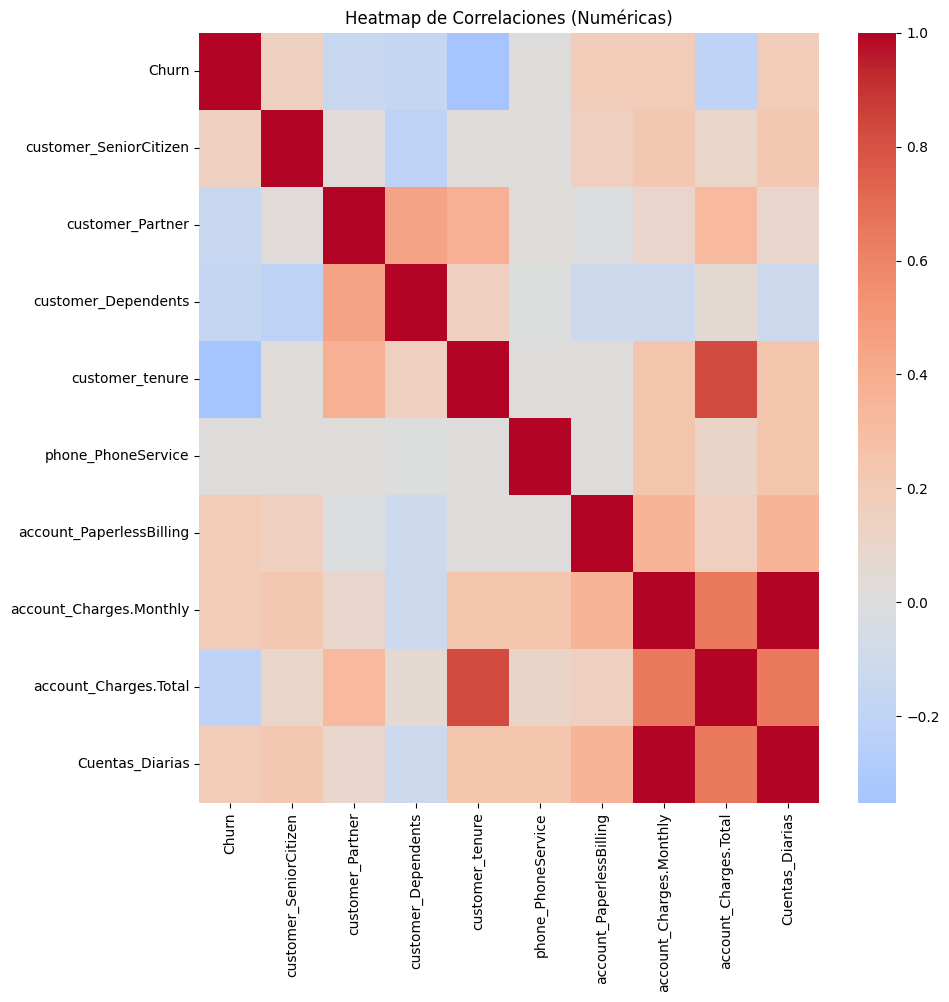

Matriz de correlación guardada en data/correlation_matrix.csv


In [65]:
# === (Opcional) Heatmap de correlaciones numéricas ===
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path

# Usar dataset limpio o model ready si existe
if Path('data/TelecomX_limpio.parquet').exists():
    corr_df = pd.read_parquet('data/TelecomX_limpio.parquet')
else:
    corr_df = df_model.copy()

num_cols_corr = [c for c in corr_df.columns if pd.api.types.is_numeric_dtype(corr_df[c])]
if len(num_cols_corr) > 1:
    corr_matrix = corr_df[num_cols_corr].corr()
    plt.figure(figsize=(min(0.6*len(num_cols_corr)+4,18), min(0.6*len(num_cols_corr)+4,18)))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
    plt.title('Heatmap de Correlaciones (Numéricas)')
    plt.show()
    corr_matrix.to_csv('data/correlation_matrix.csv')
    print('Matriz de correlación guardada en data/correlation_matrix.csv')
else:
    print('Insuficientes columnas numéricas para matriz de correlación.')

=== Classification Report (Baseline) ===
              precision    recall  f1-score   support

         0.0      0.843     0.886     0.864      1294
         1.0      0.632     0.542     0.584       467

    accuracy                          0.795      1761
   macro avg      0.738     0.714     0.724      1761
weighted avg      0.787     0.795     0.790      1761

ROC-AUC: 0.839
ROC-AUC: 0.839


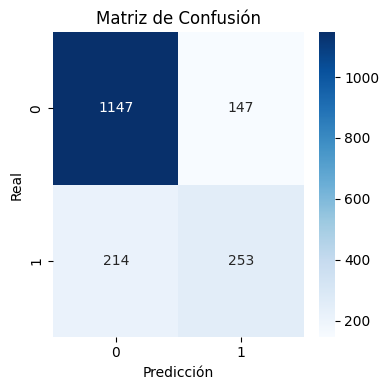

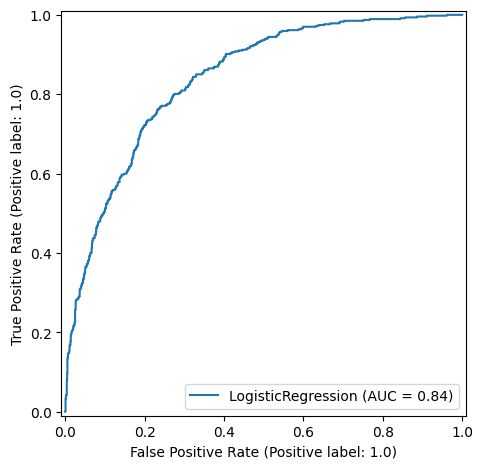

Métricas baseline guardadas en data/baseline_metrics.json


In [66]:
# === (Opcional) Modelo Baseline: Regresión Logística (robustecido) ===
import pandas as pd
from pathlib import Path
import json

# Pre-declare sklearn symbols to avoid "possibly unbound" warnings from static analysis
train_test_split = None
LogisticRegression = None
classification_report = None
roc_auc_score = None
confusion_matrix = None
RocCurveDisplay = None
precision_recall_fscore_support = None
sklearn_ok = False

try:
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import (classification_report, roc_auc_score,
                                 confusion_matrix, RocCurveDisplay, precision_recall_fscore_support)
    sklearn_ok = True
except Exception as e:
    sklearn_ok = False
    print('scikit-learn no disponible o error de importación:', e)

model_ready_path = Path('data/TelecomX_model_ready.parquet')
if not model_ready_path.exists():
    raise RuntimeError('Ejecuta la celda de dataset model ready (2.5 ampliado) antes de entrenar el baseline.')

if not sklearn_ok:
    raise RuntimeError('Instala scikit-learn para ejecutar el modelo baseline.')

full_df = pd.read_parquet(model_ready_path)
meta_path = Path('data/model_prep_metadata.json')
if not meta_path.exists():
    raise RuntimeError('Falta metadata de preparación (model_prep_metadata.json). Ejecuta 2.5 ampliado.')
meta = json.load(open(meta_path,'r', encoding='utf-8'))
TARGET = meta.get('target')
if TARGET not in full_df.columns:
    # Buscar fallback
    churn_cols = [c for c in full_df.columns if 'churn' in c.lower()]
    if churn_cols:
        TARGET = churn_cols[-1]
        print('Usando fallback target:', TARGET)
    else:
        raise RuntimeError('No se identifica columna target para el modelo.')

# Eliminar filas con NaN en el target antes del split
mask = full_df[TARGET].notna()
X = full_df.loc[mask].drop(columns=[TARGET])
y = full_df.loc[mask, TARGET]

# Validar que el target sea binario
if y.nunique() != 2:
    raise RuntimeError('Target no binaria para modelo logístico (valores únicos: %s)' % (y.unique()[:10],))

# División estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Modelo baseline (lbfgs soporta probas y es estable)
clf = LogisticRegression(max_iter=1000, solver='lbfgs')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]

print('=== Classification Report (Baseline) ===')
print(classification_report(y_test, y_pred, digits=3))
roc = roc_auc_score(y_test, y_prob)
print('ROC-AUC:', round(roc,4))

# Métricas adicionales
prec, rec, f1, sup = precision_recall_fscore_support(y_test, y_pred, average='binary')

# Matriz de confusión
import seaborn as sns, matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

# Curva ROC
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.tight_layout()
plt.show()

# Guardar métricas (cálculos robustos para support / clases)
# precision_recall_fscore_support puede devolver None para 'support' en algunas versiones/config.
try:
    support_positive = int(sup) if sup is not None else int((y_test == 1).sum())
except Exception:
    # fallback seguro: contar las instancias etiquetadas como 1 en y_test
    support_positive = int((y_test == 1).sum())

# Asegurar que las clases sean enteros serializables
try:
    # usar np.unique si está disponible en el entorno (importado en celdas previas)
    classes = [int(x) for x in sorted(np.unique(y))]
except Exception:
    classes = sorted({int(x) for x in y.dropna()})

metrics = {
    'roc_auc': float(roc),
    'precision': float(prec),
    'recall': float(rec),
    'f1': float(f1),
    'support_positive': support_positive,
    'classes': classes,
    'n_train': int(len(X_train)),
    'n_test': int(len(X_test))
}
with open('data/baseline_metrics.json','w', encoding='utf-8') as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)
print('Métricas baseline guardadas en data/baseline_metrics.json')

#📄 Informe Final

## Introducción
El presente análisis aborda la evasión de clientes (*Churn*) en Telecom X. El objetivo es identificar patrones y variables asociadas a la cancelación del servicio para apoyar decisiones orientadas a la retención.

## 1. Extracción
- Fuente: API (GitHub Raw) `TelecomX_Data.json`.
- Conversión directa a `DataFrame` y persistencia local en formato Parquet para eficiencia.

## 2. Transformación y Calidad de Datos
### 2.1 Conocimiento del dataset
- Exploración de forma, tipos y construcción de diccionario por prefijos.
- Identificación de variable objetivo de *churn*.
### 2.2 Detección de incoherencias
- Revisión de nulos, duplicados, cardinalidad, candidatos numéricos y formatos de fecha.
### 2.3 Manejo de inconsistencias
- Normalización de espacios y casing.
- Conversión de columnas casi numéricas y binarización (Yes/No → 1/0).
- Conversión de fechas potenciales.
### 2.4 Creación de `Cuentas_Diarias`
- Derivada desde cargos mensuales (`MonthlyCharges` / 30) cuando disponible.
### 2.5 Estandarización (opcional)
- Vista previa de escalado para subset numérico.

## 3. Análisis Exploratorio
### 3.1 Descriptivo
- Estadísticos de tendencia central y dispersión para variables numéricas.
### 3.2 Distribución de Churn
- Porcentaje de clientes que cancelan vs los que permanecen.
### 3.3 Churn por variables categóricas
- Identificación de categorías con mayor tasa de evasión (top spreads).
### 3.4 Churn vs variables numéricas
- Diferencias de medias y pruebas t preliminares.

## 4. Principales Hallazgos
- Variables categóricas con mayor impacto en tasas de churn: (rellenar tras revisar `churn_categorical_spread.csv`).
- Variables numéricas con mayor diferencia de medias: (consultar `churn_numeric_diff.csv`).
- Indicadores de calidad: número de columnas con nulos y columnas transformadas.

## 5. Recomendaciones
- Focalizar acciones de retención en segmentos categóricos con churn elevado.
- Diseñar ofertas personalizadas para clientes en rangos críticos de gasto / antigüedad.
- Implementar monitoreo periódico de variables detectadas como relevantes.
- Considerar modelos predictivos (árboles de decisión / gradient boosting) como siguiente fase.

---
> Este informe es auto-contenido dentro del notebook y respalda cada sección con celdas ejecutables anteriores. Actualiza los puntos entre paréntesis tras validar los archivos generados en la carpeta `data/`.


In [67]:
# (Opcional) Celda para generar texto de hallazgos automáticos a insertar manualmente en el informe.
import pandas as pd
from pathlib import Path

paths = {
    'cat_spread': Path('data') / 'churn_categorical_spread.csv',
    'num_diff': Path('data') / 'churn_numeric_diff.csv'
}

if paths['cat_spread'].exists():
    cat_spread = pd.read_csv(paths['cat_spread']).head(5)
    print('Top categóricas por spread de churn:')
    display(cat_spread)
if paths['num_diff'].exists():
    num_diff = pd.read_csv(paths['num_diff']).head(5)
    print('Top numéricas por diferencia de medias:')
    display(num_diff)

print('\nUsa estas tablas para completar la sección de Hallazgos en el informe final.')

Top categóricas por spread de churn:


,feature,spread,n_levels
0,account_Contract,0.398778,3
1,internet_InternetService,0.344878,3
2,internet_OnlineSecurity,0.343617,3
3,internet_TechSupport,0.342305,3
4,internet_OnlineBackup,0.325238,3


Top numéricas por diferencia de medias:


,feature,mean_no,mean_yes,diff,p_value
0,account_Charges.Monthly,61.265124,74.441332,13.176209,8.592449e-73
1,Cuentas_Diarias,2.042171,2.481378,0.439207,8.592449e-73
2,account_PaperlessBilling,0.535562,0.749064,0.213501,4.802979e-66
3,customer_SeniorCitizen,0.128721,0.254682,0.125961,3.587587e-29
4,phone_PhoneService,0.901044,0.909042,0.007999,3.078279e-01



Usa estas tablas para completar la sección de Hallazgos en el informe final.


In [68]:
# === Verificación de Requisitos ===
import os, json, pandas as pd
from pathlib import Path

checks = []

# 1 Extracción
checks.append({'item':'1.1 Carga desde API','ok': 'df' in globals()})
checks.append({'item':'1.2 Conversión a DataFrame','ok': isinstance(globals().get('df'), pd.DataFrame)})

# 2.1 Conoce el dataset
checks.append({'item':'2.1 Exploración tipos/shape','ok': 'summary_df' in globals() or 'feature_groups' in globals()})
checks.append({'item':'2.1 Diccionario variables','ok': Path('data/dictionary_variables.csv').exists()})
checks.append({'item':'2.1 Identificación churn','ok': 'TARGET_COL' in globals() or any('churn' in c.lower() for c in (globals().get('df_model', pd.DataFrame()).columns))})
checks.append({'item':'2.1 Relevancia simple','ok': Path('data/relevance_simple.csv').exists()})

# 2.2 Comprobación incoherencias
checks.append({'item':'2.2 Reporte nulos','ok': Path('data/quality_nulls.csv').exists()})
checks.append({'item':'2.2 Overview calidad','ok': Path('data/quality_overview.csv').exists()})

# 2.3 Manejo inconsistencias
checks.append({'item':'2.3 Dataset limpio','ok': Path('data/TelecomX_limpio.parquet').exists()})
checks.append({'item':'2.3 Binarizaciones/normalizaciones','ok': any(v in globals() for v in ['binary_map','clean_df'])})

# 2.4 Cuentas_Diarias
has_cuentas_diarias = 'df_model' in globals() and 'Cuentas_Diarias' in df_model.columns
checks.append({'item':'2.4 Cuentas_Diarias creada','ok': has_cuentas_diarias})

# 2.5 Estandarización opcional + dataset model ready
checks.append({'item':'2.5 Preview estandarización','ok': Path('data/TelecomX_limpio.parquet').exists()})
checks.append({'item':'2.5 Dataset model ready','ok': Path('data/TelecomX_model_ready.parquet').exists()})

# 3.1 Descriptivo
checks.append({'item':'3.1 Descriptivo numérico','ok': Path('data/descriptive_numeric.csv').exists()})
# 3.2 Distribución churn
checks.append({'item':'3.2 Distribución churn','ok': any('churn' in c.lower() for c in (globals().get('df_model', pd.DataFrame()).columns))})
# 3.3 Categóricas
checks.append({'item':'3.3 Churn por categóricas','ok': Path('data/churn_categorical_spread.csv').exists()})
# 3.4 Numéricas
checks.append({'item':'3.4 Churn vs numéricas','ok': Path('data/churn_numeric_diff.csv').exists()})

# Opcionales adicionales
checks.append({'item':'Opt Correlation matrix','ok': Path('data/correlation_matrix.csv').exists()})
checks.append({'item':'Opt Baseline metrics','ok': Path('data/baseline_metrics.json').exists()})

# Informe final
checks.append({'item':'Informe Final markdown','ok': True})

check_df = pd.DataFrame(checks)
print('Resumen verificación requisitos (incluye opcionales):')
print(check_df)
print('\nPendientes / Falsos:')
print(check_df[~check_df.ok])

check_df.to_csv('data/requisitos_checklist.csv', index=False)
print('\nChecklist guardado en data/requisitos_checklist.csv')

Resumen verificación requisitos (incluye opcionales):
                                  item    ok
0                  1.1 Carga desde API  True
1           1.2 Conversión a DataFrame  True
2          2.1 Exploración tipos/shape  True
3            2.1 Diccionario variables  True
4             2.1 Identificación churn  True
5                2.1 Relevancia simple  True
6                    2.2 Reporte nulos  True
7                 2.2 Overview calidad  True
8                   2.3 Dataset limpio  True
9   2.3 Binarizaciones/normalizaciones  True
10          2.4 Cuentas_Diarias creada  True
11         2.5 Preview estandarización  True
12             2.5 Dataset model ready  True
13            3.1 Descriptivo numérico  True
14              3.2 Distribución churn  True
15           3.3 Churn por categóricas  True
16              3.4 Churn vs numéricas  True
17              Opt Correlation matrix  True
18                Opt Baseline metrics  True
19              Informe Final markdown  True



In [69]:
# === Diagnóstico de Entorno (paquetes clave) ===
import importlib, sys, platform
packages = ['pandas','numpy','pyarrow','sklearn','scipy','matplotlib','seaborn']
info = []
for p in packages:
    try:
        m = importlib.import_module(p)
        ver = getattr(m,'__version__','?')
        info.append((p, ver))
    except Exception as e:
        info.append((p, f'NO INSTALADO ({e.__class__.__name__})'))
print('Versiones paquetes:')
for name, ver in info:
    print(f'- {name}: {ver}')
print('\nPython:', sys.version)
print('Platform:', platform.platform())

Versiones paquetes:
- pandas: 2.3.1
- numpy: 2.3.2
- pyarrow: 21.0.0
- sklearn: 1.7.1
- scipy: 1.16.1
- matplotlib: 3.10.5
- seaborn: 0.13.2

Python: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
Platform: Windows-11-10.0.26100-SP0
